# Import Images

In [1]:
import os
import skimage
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np

plt.rcParams["figure.figsize"] = (5,5)

In [2]:
folder_path = 'Images'

file_paths = []

# List all files in the folder
for filename in os.listdir(folder_path):
    # Join the folder path with the filename to get the full path
    file_path = os.path.join(folder_path, filename)
    
    # Check if the path is a file (not a directory)
    if os.path.isfile(file_path):
        # Append the file path to the list
        file_paths.append(file_path)

In [3]:

images = skimage.io.imread_collection(file_paths)

In [4]:
images[0].shape

(3024, 4032, 3)

# Downscale, Convert to Grayscale

In [5]:
images_ds = []
scaling = 0.1
for image in images:
    im = skimage.color.rgb2gray(image)
    im = skimage.transform.rescale(image = im, scale = scaling)
    im = skimage.img_as_float(im)
    images_ds.append(im)

In [6]:
@widgets.interact(image = range(len(images_ds)))
def f(image):
   plt.imshow(images_ds[image], cmap="gray")

interactive(children=(Dropdown(description='image', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

# Canny Edges + Hough Transform

In [7]:
@widgets.interact(hough_threshold=(0,500,1),
                  disk_size=(0,30),
                  contrast = (0.0,1.0,0.01),
                  brightness = (0.0,1.0,0.01),
                  canny_sigma=(0.0,20),
                  canny_low_threshold=(0.0,1.0,0.001),
                  canny_high_threshold=(0.001,0.1,0.001))
def f(disk_size = 5, contrast = 0.5, brightness = 0, canny_sigma = 4, canny_low_threshold = 0.001, canny_high_threshold = 0.05, hough_threshold = 200):
    for i in range(len(images_ds)):
        #preprocessing
        im = skimage.filters.median(images_ds[i],skimage.morphology.disk(disk_size))*contrast + brightness
        #canny edges
        im_edges = skimage.feature.canny(im, sigma=canny_sigma, mode = "nearest", low_threshold=canny_low_threshold, high_threshold=canny_high_threshold)
        #hough lines
        h, theta, d = skimage.transform.hough_transform.hough_line(im_edges)
        #4 strongest lines
        accum, angles, dists = skimage.transform.hough_transform.hough_line_peaks(h, theta, d, min_distance=50, threshold=10, num_peaks=4)
        #plot
        fig, axs = plt.subplots(ncols=2, figsize=(5,5))
        axs[0].imshow(im, cmap="gray")
        for acc, angle, dist in zip(accum, angles, dists):
            (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
            axs[0].axline((x0, y0), slope=np.tan(angle + np.pi/2))
    
        axs[0].set_title(f"Detected lines image {i+1}")
        axs[1].imshow(im_edges)
        axs[1].set_title(f"Canny edges image {i+1}")

interactive(children=(IntSlider(value=5, description='disk_size', max=30), FloatSlider(value=0.5, description=…

In [8]:
# parameters found with widget
disk_size = 5
contrast = 0.5
brightness = 0.0
canny_sigma = 4
canny_low_threshold = 0.001
canny_high_threshold = 0.06  

lines_pics = []
ims_edges = []

for i in range(len(images_ds)):
    #preprocessing
    im = skimage.filters.median(images_ds[i],skimage.morphology.disk(disk_size))*contrast + brightness
    #canny edges
    im_edges = skimage.feature.canny(im, sigma=canny_sigma, mode = "nearest", low_threshold=canny_low_threshold, high_threshold=canny_high_threshold)
    #hough lines
    h, theta, d = skimage.transform.hough_transform.hough_line(im_edges)
    #4 strongest lines
    accum, angles, dists = skimage.transform.hough_transform.hough_line_peaks(h, theta, d, min_distance=50, threshold=10, num_peaks=4)
    #put all 4 lines in one array
    lines_pic = []
    for ac, angle, dist in zip(accum, angles, dists):
        lines_pic.append([angle, dist])
    #append all to global list
    lines_pics.append(lines_pic)
    ims_edges.append(im_edges)


# Homogeneous Coordinates

/tmp/ipykernel_61115/2902188331.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,(ax0) = plt.subplots(1,1)


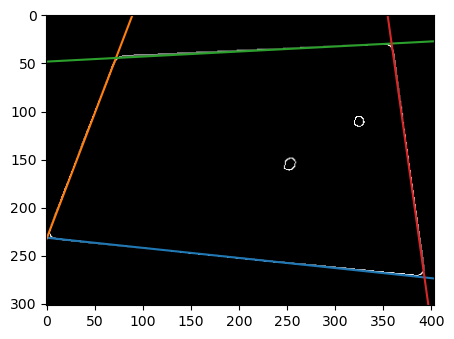

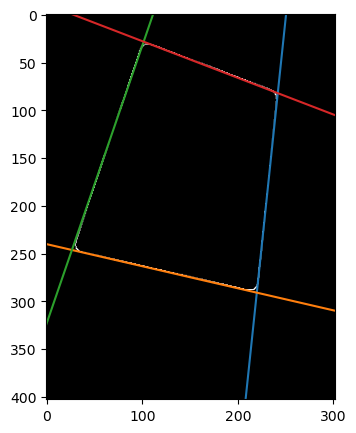

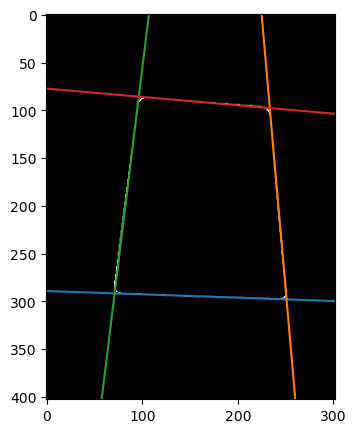

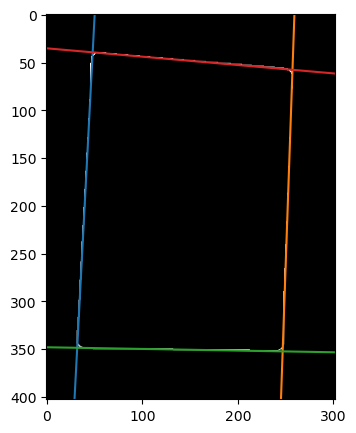

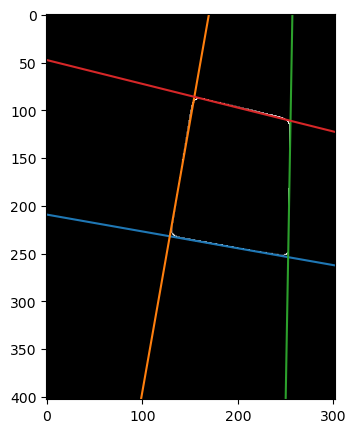

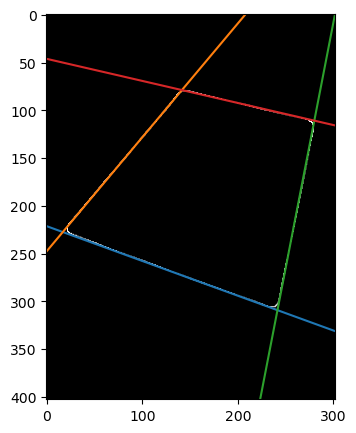

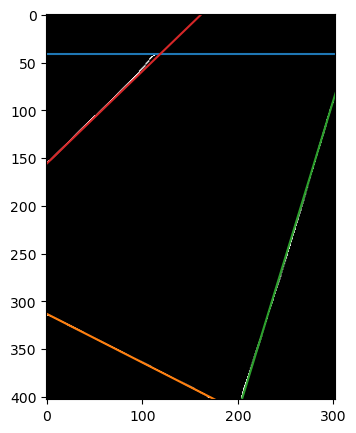

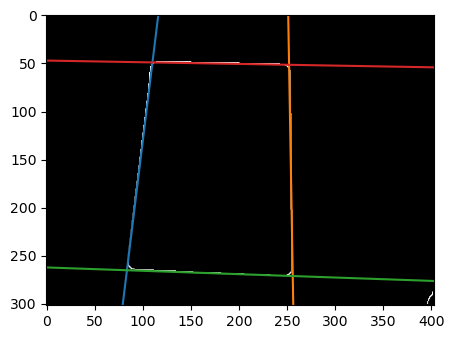

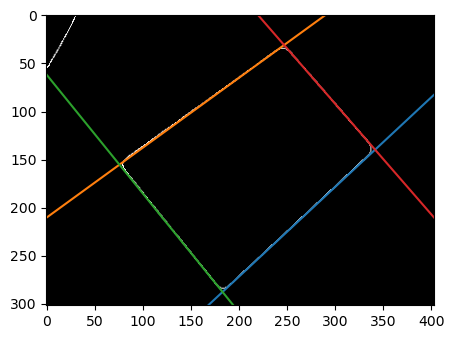

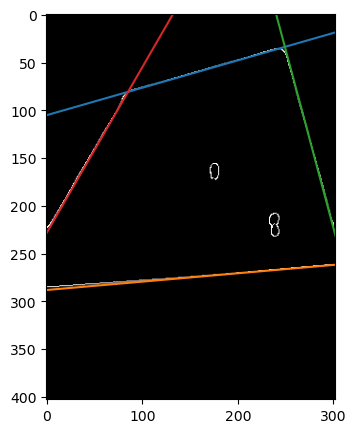

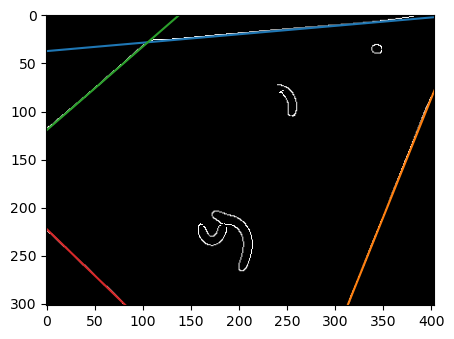

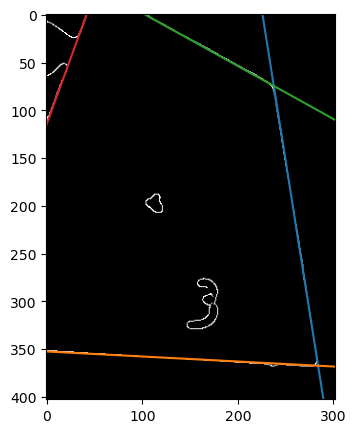

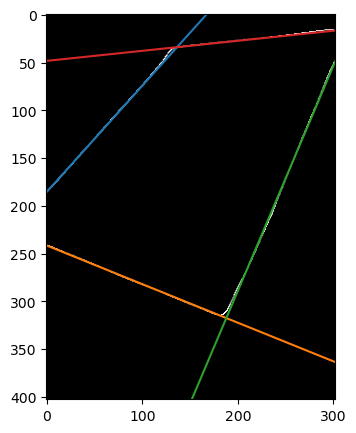

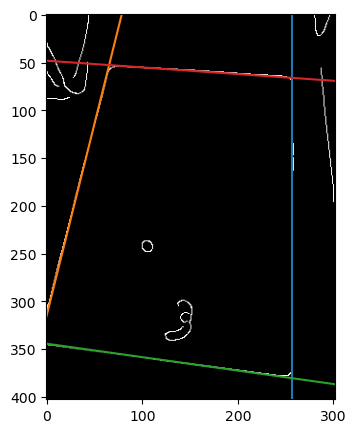

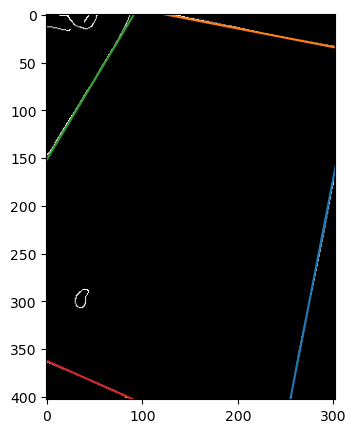

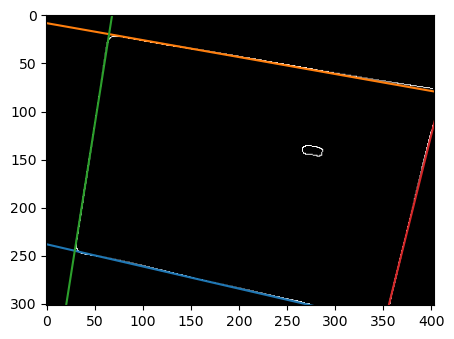

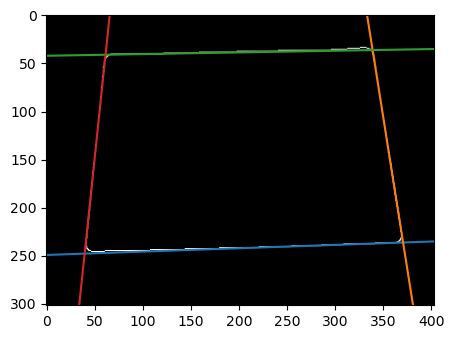

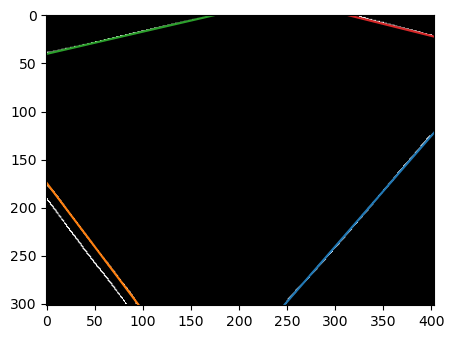

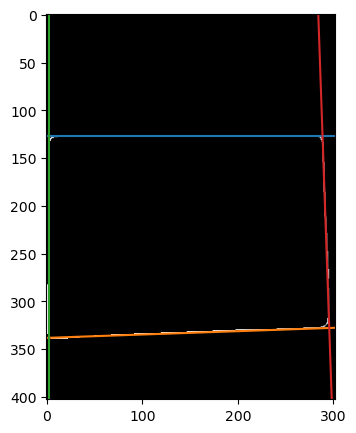

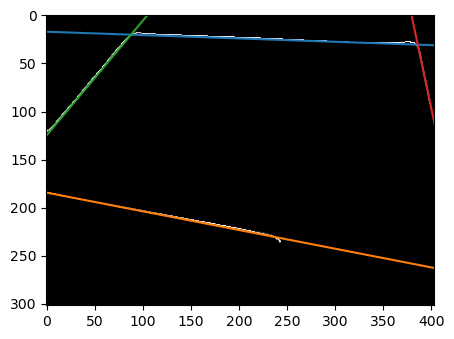

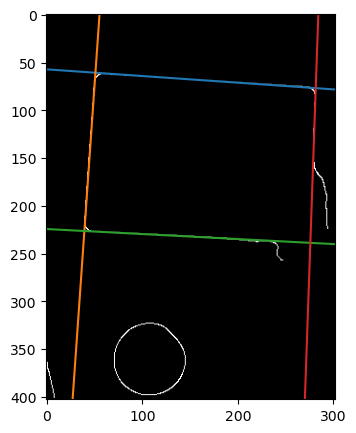

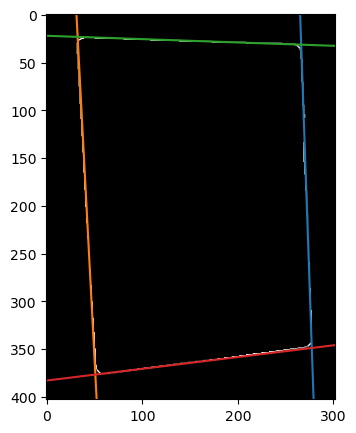

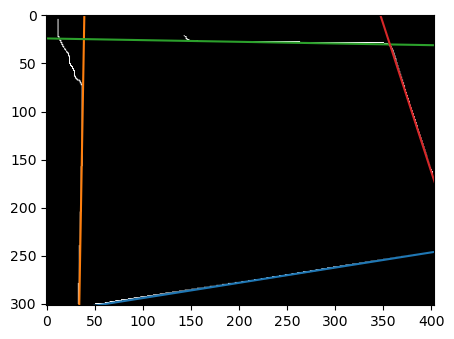

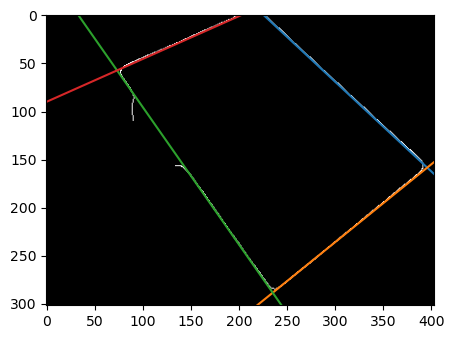

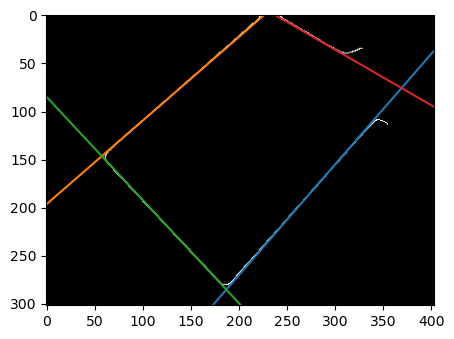

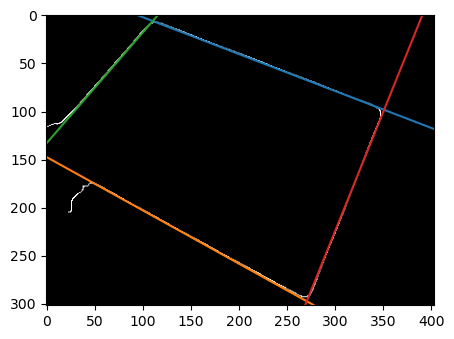

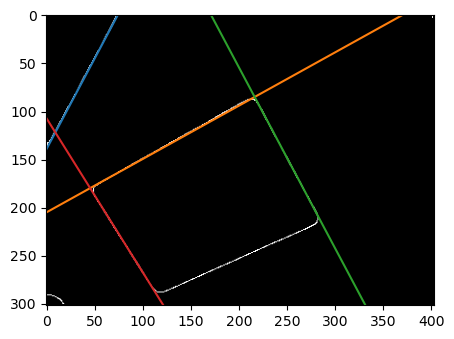

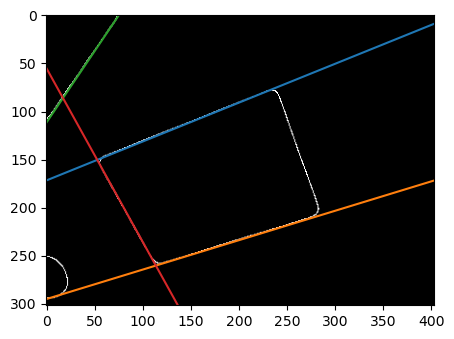

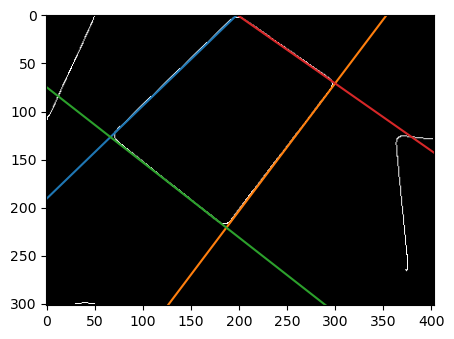

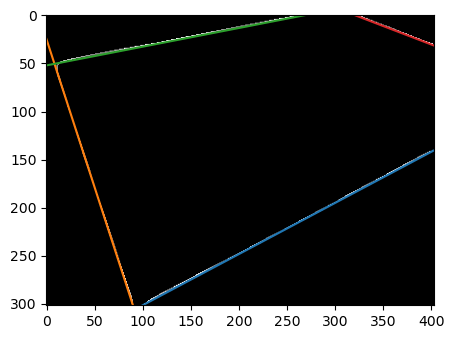

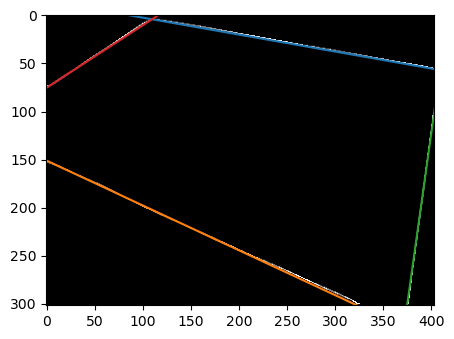

In [9]:
#convert to homogeneous coordinates
h_coordinates = []
for i, lines_pic in enumerate(lines_pics):
    h_coordinates_per_pic = []
    #plot
    fig,(ax0) = plt.subplots(1,1)
    ax0.imshow(ims_edges[i], cmap="gray", vmin=0, vmax=1)

    for line in lines_pic:
        angle = line[0]
        dist = line[1]
        #nearest point to origin
        p0 = np.array([dist*np.cos(angle), dist*np.sin(angle)])
        #slope
        slope = np.array([np.cos(angle+np.pi/2), np.sin(angle+np.pi/2)])
    
        #2 points with 1000 pixels distance
        p1 = p0 - slope * 1000
        p2 = p0 + slope * 1000
        
        ax0.plot([p1[0],p2[0]],[p1[1],p2[1]], scalex=False, scaley=False)
        
        h_coordinates_per_pic.append(np.cross(np.append(p1,1),np.append(p2,1)))
    
    h_coordinates.append(h_coordinates_per_pic)